# 5. CNN을 이용한 분류 (CIFAR10)

합성곱 신경망(Convolutional Neural Network)를 이용한 이미지 분류

In [1]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import trange # for문의 진행 상황을 bar 형태로 출력

## 5.1 CIFAR10 데이터 불러오기

In [4]:
# CIFAR10: 클래스 10개를 가진 이미지 데이터
# 'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=32, shuffle=True) 

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
# CPU/GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cuda:0 is available.


## 5.2 CNN 모델 구축

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 합성곱 연산 (입력 채널수 3, 출력 채널수 6, 필터크기 5x5 , stride=1(defualt))
        self.pool1 = nn.MaxPool2d(2, 2) # 합성곱 연산 (필터크기 2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5) # 합성곱 연산 (입력 채널수 6, 출력 채널수 16, 필터크기 5x5 , stride=1(defualt))
        self.pool2 = nn.MaxPool2d(2, 2) # 합성곱 연산 (필터크기 2, stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 5x5 피쳐맵 16개를 일렬로 피면 16*5*5개의 노드가 생성
        self.fc2 = nn.Linear(120, 10) # 120개 노드에서 클래스의 개수인 10개의 노드로 연산

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x))) # conv1 -> ReLU -> pool1
        x = self.pool2(F.relu(self.conv2(x))) # conv2 -> ReLU -> pool2
        x = x.view(-1, 16 * 5 * 5) # 5x5 피쳐맵 16개를 일렬로 만든다.
        x = F.relu(self.fc1(x)) 
        x = self.fc2(x)

        return x

In [7]:
net = CNN().to(device) # 모델 선언
print(net)
# 피쳐의 크기: 32 -> 28 ->14 -> 10 -> 5

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)


## 5.3 모델 학습하기

In [8]:
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss는 softmax 계산까지 포함되어 있으므로 모델의 마지막 output node에 별도의 활성화 함수를 사용하지 않아도 된다.
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

In [9]:
# 모델의 학습 과정인 4강에서 배운 인공 신경망과 동일하다.
loss_ = [] # 그래프를 그리기 위한 loss 저장용 리스트 
n = len(trainloader) # 배치 개수
num_epochs = 10
pbar = trange(num_epochs)

for epoch in pbar:  # 10번 학습을 진행한다.

    running_loss = 0.0
    for data in trainloader:

        inputs, labels = data[0].to(device), data[1].to(device) # 배치 데이터 
        
        optimizer.zero_grad()

        outputs = net(inputs) # 예측값 산출 
        loss = criterion(outputs, labels) # 손실함수 계산
        loss.backward() # 손실함수 기준으로 역전파 선언
        optimizer.step() # 가중치 최적화

        # print statistics
        running_loss += loss.item()

    l = running_loss/n
    loss_.append(l)   
    pbar.set_postfix({'epoch': epoch+1, 'loss' : l}) 

100%|██████████| 10/10 [02:38<00:00, 15.81s/it, epoch=10, loss=1.09]


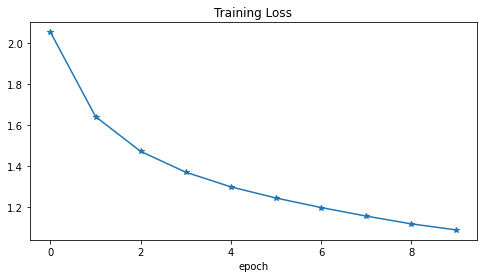

In [10]:
plt.figure(figsize=(8, 4))
plt.plot(loss_, '-*')
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

## 5.4 모델 저장하기

In [11]:
PATH = './models/cifar_net.pth' # 모델 저장 경로 
torch.save(net.state_dict(), PATH) # 모델 저장

## 5.5 모델 불러오기

In [12]:
# 모델 불러오기는 엄밀히 말하자면 모델의 파라메타를 불러오는 것이다. 따라서 모델의 뼈대를 먼저 선언하고
# 모델의 파라메타를 불러와 pretrained model을 만든다.

net = CNN().to(device) # 모델 선언
net.load_state_dict(torch.load(PATH)) # 모델 파라메타 불러오기

<All keys matched successfully>

## 5.6 모델 정확도(Accuracy) 구하기

In [13]:
# 평가 데이터를 이용해 정확도를 구해보자.
# output은 미니배치의 결과가 산출되기 때문에 for문을 통해서 test 전체의 예측값을 구한다.

correct = 0
total = 0
with torch.no_grad():
    net.eval()
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # 개수 누적(총 개수)
        correct += (predicted == labels).sum().item() # 누적(맞으면 1, 틀리면 0으로 합산)
        
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 60 %
